In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [4]:
# train ... new datasets, ...
outdir = 'history/2019-12-22T174803Z'
train_loc = f'{outdir}/train_balanced.h5'
test_loc = f'{outdir}/test_balanced.h5'

print(mu.h5_keys(train_loc))
print(mu.h5_keys(test_loc))

['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']
['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [5]:
# ok save the shuffled dataset too for repeatability...
# Grab and randomize since it's not huge...
vecs = [mu.read_h5_two(
                source_location=train_loc, 
                Xdataset=f'X_{i}',
                Ydataset=f'Ylabels_{i}')
                 for i in [0, 1, 2, 3]]

X_train = np.concatenate([x[0] for x in vecs])
Ylabels_train = np.concatenate([x[1] for x in vecs])

# Shuffle...
size = X_train.shape[0]
print(size)
indices = np.random.choice(range(size), size=size, replace=False)
X_train_shfl = X_train[indices]
Ylabels_train_shfl = Ylabels_train[indices].astype('int64')

X = X_train_shfl
Ylabels = Ylabels_train_shfl


# SAVE ...



mu.save_that(save_location=f'{outdir}/train_scaled_balanced_shuffled.h5', 
             name='X', X=X)


34980


In [8]:
# Parameters..

# Working dir... 
save_dir = 'history'
BATCH_SIZE = 32
ts = mu.quickts(); print('starting,', ts)

size = X.shape[0]
workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')

#learning_rate = 
# 'batch_size'
lstm_params = {
    'units': 64,
    'dropout': 0.7,
    'recurrent_dropout': 0.7,
    'batch_input_shape': (None, 64, 8),
    }

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(**lstm_params),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)])

# save base unfitted model.
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')


starting, 2019-12-25T181637Z
Made new workdir, history/2019-12-25T181637Z


In [9]:


model = mu.load_model(f'{workdir}/00000__unfitted_model.h5')

class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
with ipdb.launch_ipdb_on_exception():
    mu.do_train(
        model,
        dataset_batches,
        k=size,
        saveloc=workdir)

W1225 18:17:57.218597 140461759739712 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:185: RuntimeWarning: divide by zero encountered in true_divide
  )/class_counts
W1225 18:17:57.573302 140461759739712 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

0it [00:00, ?it/s]W1225 18:17:57.873211 140461759739712 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:246: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

W1225 18:17:57.876062 140461759739712 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/

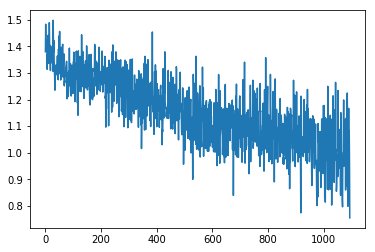

In [11]:
historydir = 'history'
with open(f'{workdir}/01093_train_loss_history.json') as fd:
    losshistory = json.load(fd)
    
plt.plot(losshistory) 

In [12]:
import mytf.validation as mv
print(ts)

2019-12-25T181637Z


In [ ]:
%%time
batch_losses_vec = []
#sess = tf.Session()
#with sess.as_default():
for step in tqdm(np.arange(0, 1094, 10)):
    #print(step)
    modelname = f'history/{ts}/{str(step).zfill(5)}_model.h5'
    #print(modelname)
    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True)
    #print('steploss, ', steploss)
    batch_losses_vec.append([float(x) for x in steploss])
    mv.json_save({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'history/{ts}/{str(step).zfill(5)}_validation_losses.json')

100%|██████████| 110/110 [4:00:03<00:00, 130.94s/it]

CPU times: user 3h 59min 24s, sys: 19.6 s, total: 3h 59min 44s
Wall time: 4h 3s


In [ ]:
# Hmm interesting information about this compile warning, 
# in https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c  
# I have not used this model.compile() recently.

In [16]:
# crap I forgot to save the shuffled ylabels..


mu.save_that(save_location=f'{outdir}/train_scaled_balanced_shuffled.h5', 
             name='Ylabels', X=Ylabels)

In [17]:
mu.h5_keys(f'{outdir}/train_scaled_balanced_shuffled.h5')

['X', 'Ylabels']

In [18]:
len(batch_losses_vec)

110

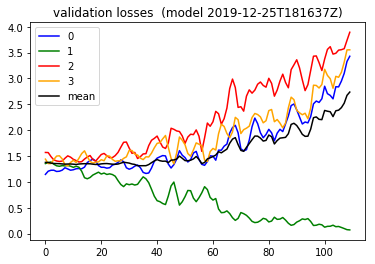

In [20]:
# .... hopefully if some of that stuff finishes ..
# I can run this ... 
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()
#plt.plot
